Importing gempy



In [1]:
%matplotlib inline
from pyvista import set_plot_theme
set_plot_theme('document')
import gempy as gp

# Aux imports
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
import gstools as gs
import pyvista as pv
import pyvistaqt as pvqt
import PVGeo
import glob
import random
from tqdm import tqdm

np.random.seed(1515)
pd.set_option('precision', 2)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`


No module named 'osgeo'


C:\Users\pasha\python\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


We import a model from an existing folder, representing a subduction
zone with onlap relationships. The theano function is automatically
recombined to allow changes.




In [2]:
#define resolution and mesh size
reso=[50, 50, 50]
mesh_size = reso[0]*reso[1]*reso[2]
extent=[0, 1588, 0, 1100, -1164, 50]
print(' mesh size: ' + str(mesh_size))

 mesh size: 125000


In [3]:
surface_points=pd.read_csv('data_all_test100.csv')
orientations=pd.read_csv('data_all_test100.csv')

In [4]:
geo_data = gp.create_data('foresets', extent=extent, resolution=reso)
geo_data.set_surface_points(surface_points)
geo_data.set_orientations(orientations)
geo_data.resolution=reso

Active grids: ['regular']


In [5]:
gp.map_stack_to_surfaces(geo_data, {"Strat_Series1":('topo'),
                                    "Strat_Series2":('linglongbiotitegranite'),
                                    "Strat_Series3":('pyritesericitequartzalterationzone'),
                                    "Strat_Series4":('sericitequartzalterationzone','Kfeldspathizationzone')})
geo_data.add_series("Basement")
geo_data.add_surfaces('basement')

,surface,series,order_surfaces,color,id
0,topo,Strat_Series1,1,#015482,1
1,linglongbiotitegranite,Strat_Series2,1,#9f0052,2
2,pyritesericitequartzalterationzone,Strat_Series3,1,#ffbe00,3
3,sericitequartzalterationzone,Strat_Series4,1,#728f02,4
4,Kfeldspathizationzone,Strat_Series4,2,#443988,5
5,basement,Basement,1,#ff3f20,6


In [6]:
geo_data.series

,order_series,BottomRelation,isActive,isFault,isFinite
Strat_Series1,1,Erosion,True,False,False
Strat_Series2,2,Erosion,True,False,False
Strat_Series3,3,Erosion,True,False,False
Strat_Series4,4,Erosion,True,False,False
Basement,5,Erosion,False,False,False


C:\Users\pasha\python\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


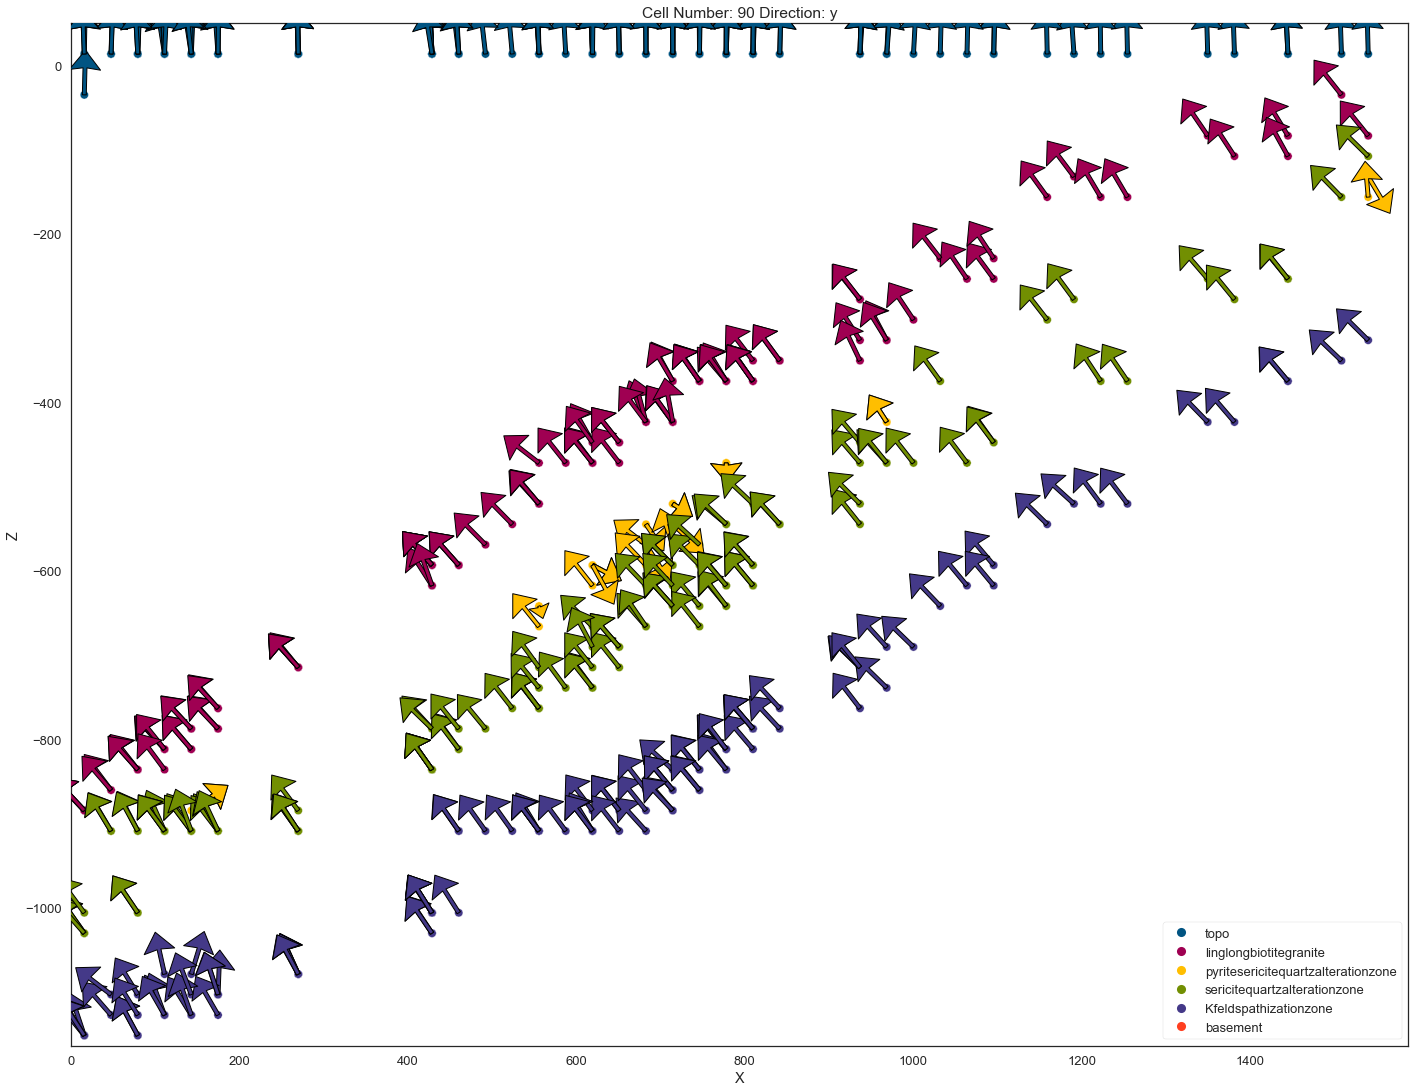

In [7]:
#for resolution of 100x100x100 : #1000m 90 in y direction
gp.plot_2d(geo_data, cell_number=90, show_data=True, figsize=(20,20)) #58 #29

In [8]:
#set topography surface for good visualization
geo_data.set_topography()

[-192.8   50. ]
Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[   15.88      ,    11.        , -1151.86      ],
       [   15.88      ,    11.        , -1127.58      ],
       [   15.88      ,    11.        , -1103.3       ],
       ...,
       [ 1588.        ,  1055.10204082,  -148.19186469],
       [ 1588.        ,  1077.55102041,  -144.08548628],
       [ 1588.        ,  1100.        ,  -143.58951657]])

In [9]:
interp_data = gp.set_interpolator(geo_data, compile_theano=True,theano_optimizer='fast_compile')

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                           values
range                    2281.57
$C_o$                  123941.43
drift equations  [3, 3, 3, 3, 3]


In [10]:
%%time
sol = gp.compute_model(geo_data, compute_mesh=True, debug=False)

Wall time: 1min 7s


C:\Users\pasha\python\lib\site-packages\gempy\core\solution.py:174: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.geological_map = np.array(


C:\Users\pasha\python\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


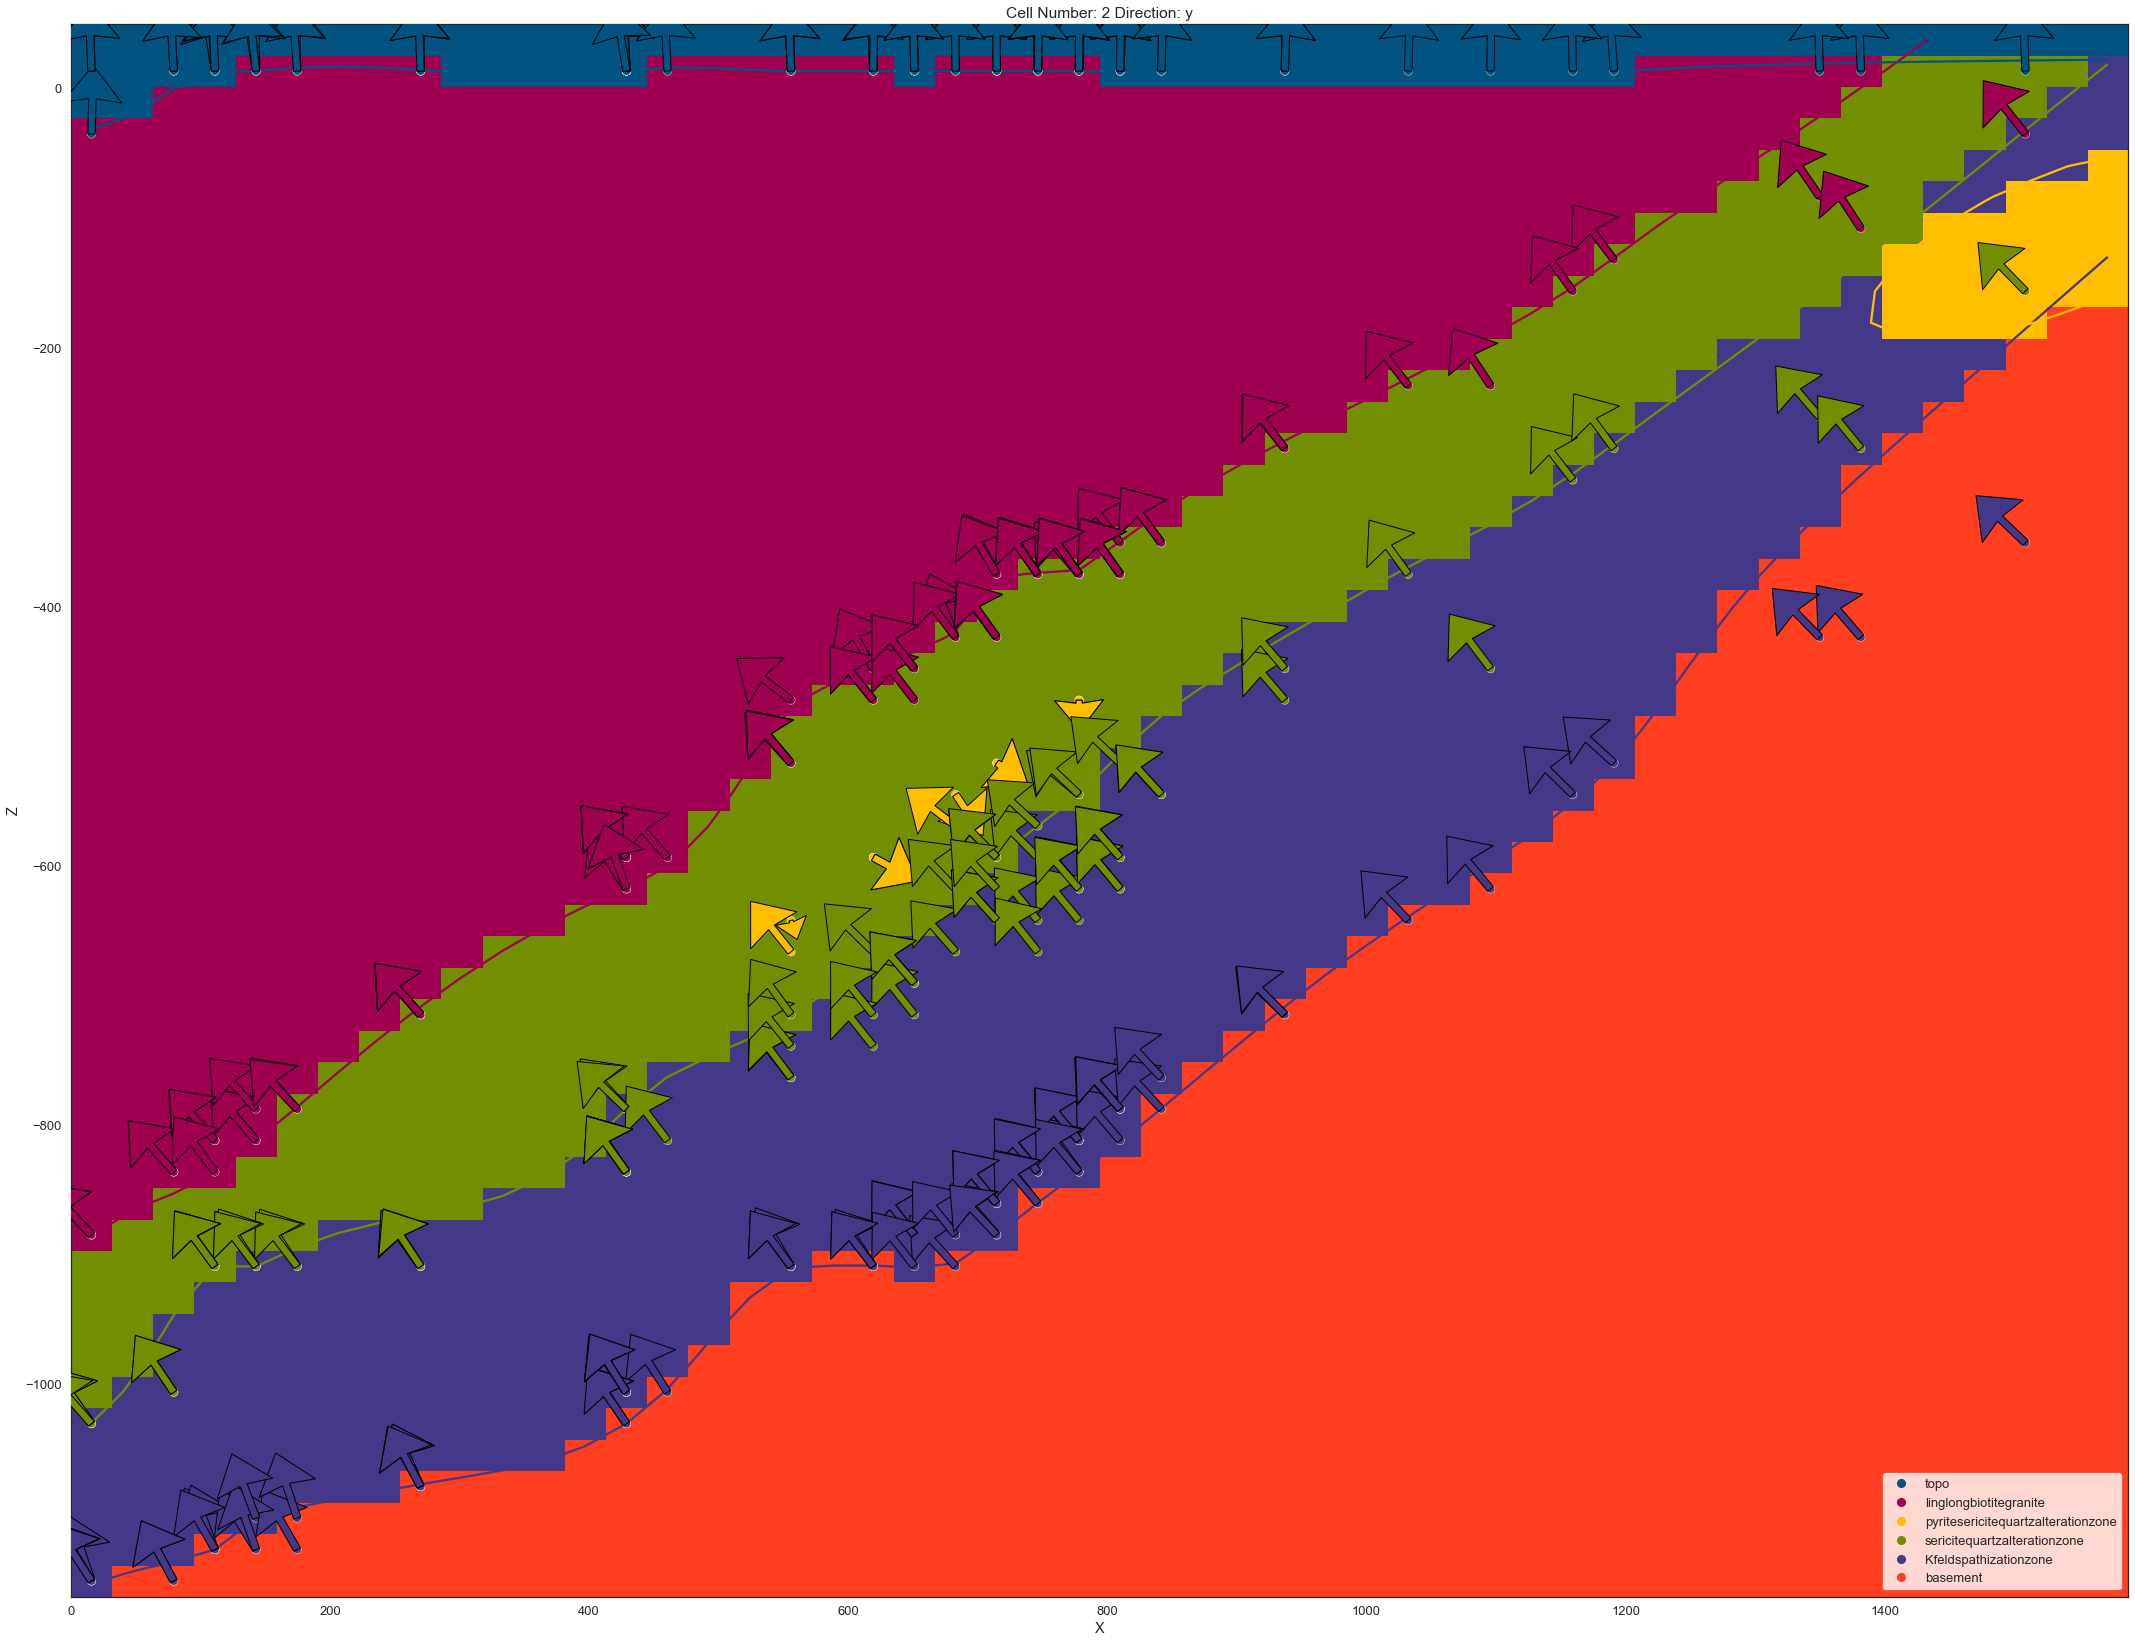

In [11]:
gp.plot_2d(geo_data, direction='y', cell_number=2, show_data=True,  figsize=(30,30))

In [373]:
p3d = gp.plot_3d(geo_data, plotter_type='background', show_lith=True, show_surfaces=True,  show_data=False, image=False,
                 show_topography=True,
                 kwargs_plot_structured_grid={'opacity': .7})

gp.save_model(geo_data)

C:\Users\pasha\python\lib\site-packages\pyvista\plotting\plotting.py:1354: PyvistaDeprecationWarning: 
"stitle" is a depreciated keyword and will be removed in a future
release.

Use ``scalar_bar_args`` instead.  For example:

scalar_bar_args={'title': 'Scalar Bar Title'}

  warnings.warn(USE_SCALAR_BAR_ARGS, PyvistaDeprecationWarning)


True

In [12]:
### User-defined functions
def extract_domain(sol, unit):
    '''
    Extract domain coordinates from gempy model by unit name
    arguments:
        sol: Gempy solution object.
        unit: gempy unit by index
    returns:
        dom_x, dom_y, dom_z: coordinates of domain
    '''

    # new version with rounding, definitely necessary
    rounded_lithblock = sol.lith_block.round(0)
    rounded_lithblock = rounded_lithblock.astype(int)

    # mask by array of input surfaces (by id, can be from different series)
    mask = np.isin(rounded_lithblock, unit)

    # get coordinates by mask, mesh_size is defined on in[55]
    #krig_lith = sol.lith_block[mask]
    dom_grid = sol.grid.values[:mesh_size][mask]

    dom_x = dom_grid[:,0]
    dom_y = dom_grid[:,1]
    dom_z = dom_grid[:,2]

    return dom_x, dom_y, dom_z

In [13]:
unit_count=int(np.max(sol.lith_block.round(0)))
unit_count

6

### Geostatistics and Kriging
the script below is designed to use two different mineral grading parameters and eventually visualize both in the same grid of the model

In [14]:
#load csv file and introduce it to pandas dataframe
df=pd.read_csv('3_kriging_100.csv')
df

,Unnamed: 0,X,Y,Z,grade,borehole
0,0,682.84,1065.5,-666.26,7.82,1.0
1,2,682.84,1065.5,-617.70,7.82,1.0
2,4,682.84,1065.5,-569.14,7.82,1.0
3,6,174.68,559.5,-957.62,7.90,2.0
4,8,174.68,559.5,-909.06,7.86,2.0
...,...,...,...,...,...,...
256,512,746.36,375.5,-569.14,7.78,99.0
257,514,746.36,375.5,-520.58,7.60,99.0
258,516,968.68,697.5,-496.30,7.81,100.0
259,518,968.68,697.5,-447.74,7.79,100.0


In [15]:
# This is to extract smaller domains from gempy by (4,)
domain_x, domain_y, domain_z = extract_domain(sol, (3,4))

# grid coordinate preparation
coordinates = np.array([domain_x, domain_y, domain_z])
coordinates = coordinates.swapaxes(0,1)

In [16]:
# define kriging points coordinates and grade values (Cu)
n=len(df.iloc[:,2])
x = df.iloc[:n,1]
y = df.iloc[:n,2]
z = df.iloc[:n,3]
cond_pos = np.array([x,y,z])
cond_val = df.iloc[:n,4]

In [17]:
# Define kriging function
model = gs.Exponential(dim=3, var=np.var(cond_val), len_scale=200)
krige = gs.krige.Ordinary(model, cond_pos, cond_val)

# perform kriging
krige((coordinates[:,0],coordinates[:,1], coordinates[:,2]), mesh_type='unstructured')
# alternatively fior SGS
#cond_srf((coordinates[:,0],coordinates[:,1], coordinates[:,2]), mesh_type='unstructured')

# just convenience rename
field= krige

In [18]:
# convert to pyvista mesh
pc = field.to_pyvista()

In [19]:
# 3D plotting example of Cu krige
spacing = lambda arr: np.unique(np.diff(np.unique(arr)))
voxelsize = spacing(pc.points[:,0]), spacing(pc.points[:,1]), spacing(pc.points[:,2])

pc = pc.cast_to_unstructured_grid()

grade = PVGeo.filters.VoxelizePoints(dx=voxelsize[0][0], dy=voxelsize[1][0], dz=voxelsize[2][0], 
                                        estimate=False).apply(pc)


#a = pc_Cu.plot('3d_field')
#p = pvqt.BackgroundPlotter(pc)


gpv = gp.plot_3d(geo_data, plotter_type='background', show_data=False, show_lith=True, show_surfaces=False,
                kwargs_plot_structured_grid={'opacity': 1})

gpv.p.add_mesh(grade, opacity=1, show_edges=False, lighting=False, cmap="viridis")

C:\Users\pasha\python\lib\site-packages\pyvista\plotting\plotting.py:1354: PyvistaDeprecationWarning: 
"stitle" is a depreciated keyword and will be removed in a future
release.

Use ``scalar_bar_args`` instead.  For example:

scalar_bar_args={'title': 'Scalar Bar Title'}

  warnings.warn(USE_SCALAR_BAR_ARGS, PyvistaDeprecationWarning)


(vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)00000254905E54C0

In [21]:
#define grade intervals and check the count of voxels corresponding to the same interval
ore_interval1=[]
ore_interval2=[]
ore_dict={}
for index in tqdm(range(0, len(grade.active_scalars))):
    #for Cluster I:
    if 7.8>grade.active_scalars[index]>7.7:
        ore_interval1.append(grade.active_scalars[index])
        ore_dict.update({1: ore_interval1})
    #for Cluster II:
    elif 8.8>grade.active_scalars[index]>8.0:        
        ore_interval2.append(grade.active_scalars[index])
        ore_dict.update({2: ore_interval2})
        
#calculate volume of total voxels corresponding to a certain ore grade interval
voxel_volume=((extent[1]-extent[0])/reso[0])*((extent[3]-extent[2])/reso[1])*((extent[5]-extent[4])/reso[2])

for i in range(1,3):
    ore_avrg_grade=np.mean(ore_dict[i])
    volume=len(ore_dict[i])*(voxel_volume)
    print('Horizon1',volume)
    print("Average ore grade=", ore_avrg_grade)

100%|████████████████████████████████| 149871/149871 [01:17<00:00, 1922.82it/s]

Horizon1 102482970.7704
Average ore grade= 7.770827026762018
Horizon1 2909484.0544000003
Average ore grade= 8.080782320242998


### Compare the data frames with with identical cells

In [20]:
unit=range(0,unit_count+1)
for index in unit:
    domain_x, domain_y, domain_z = extract_domain(sol, (unit[index+1]))
    coordinates = np.array([domain_x, domain_y, domain_z])
    coordinates = coordinates.swapaxes(0,1)
    data=pd.DataFrame(coordinates, columns=['X','Y','Z'])
    data.loc[:, 'formation'] =float(unit[index+1])
    data.to_csv(r'data_extracted/reconstructed/unit_{}.csv'.format(unit[index+1]), mode="w", index=False)

IndexError: range object index out of range

In [21]:
# if you want to join all files in the same folder
path =r'data_extracted/reconstructed/'

filenames = glob.glob(path + "/*.csv")

dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename))

# Concatenate all data into one DataFrame
reconstructed = pd.concat(dfs, ignore_index=True)
#df.drop(df.columns[[0]], axis=1, inplace=True)
reconstructed

,X,Y,Z,formation
0,15.88,11.0,-10.70,1.0
1,15.88,11.0,13.58,1.0
2,15.88,11.0,37.86,1.0
3,15.88,33.0,-10.70,1.0
4,15.88,33.0,13.58,1.0
...,...,...,...,...
124995,1572.12,1089.0,-399.18,6.0
124996,1572.12,1089.0,-374.90,6.0
124997,1572.12,1089.0,-350.62,6.0
124998,1572.12,1089.0,-326.34,6.0


In [24]:
# if you want to join all files in the same folder
path =r'data_extracted/ideal/'

filenames = glob.glob(path + "/*.csv")

dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename))

# Concatenate all data into one DataFrame
ideal = pd.concat(dfs, ignore_index=True)
#df.drop(df.columns[[0]], axis=1, inplace=True)
ideal

,X,Y,Z,formation
0,15.88,11.0,-34.98,1.0
1,15.88,11.0,-10.70,1.0
2,15.88,11.0,13.58,1.0
3,15.88,11.0,37.86,1.0
4,15.88,33.0,-34.98,1.0
...,...,...,...,...
124995,1572.12,1089.0,-423.46,6.0
124996,1572.12,1089.0,-399.18,6.0
124997,1572.12,1089.0,-374.90,6.0
124998,1572.12,1089.0,-350.62,6.0


In [25]:
a=ideal.merge(reconstructed, left_on=('X','Y','Z','formation'), right_on=('X','Y','Z','formation'), how='inner')
similarity=(len(a)/len(ideal))*100
similarity

90.5696